# Crime Data Analysis

This analysis focuses on crime rates in US communities in 2018. I used a publicly available dataset downloaded from kaggle. The original dataset included 146 columns, but I narrowed it down to the most relevant features for this project. The primary goal is to understand the factors influencing violent crime rates and to predict violent crime rates per population using socioeconomic, geographical, and demographic variables. Understanding the factors that influence crime rates is crucial for developing policies to reduce crime.

#### Objective: 

To investigate the several key questions:
1.  How do features like population, demographics, and socioeconomic factors influence crime rates in U.S cities?
2. What features are most strongly correlated with crime rates?
3. Can a predictive model be built to estimate crime rates based on these features?
4. Are there noticeable patterns between different crime categories, such as violent vs. non-violent?


I aim to build reliable and accurate **Linear Regression** models to analyze crime. This process starts with data cleaning, followed by a thorough EDA, and then I will develop multiple regression models and compare their performance. Throughout this notebook, I will explore the relationships between various factors and crime rates, create visualizations for a deeper understanding, and answer the key questions through data analysis and modeling. 


In [137]:
# Load the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load in data
df = pd.read_csv('crimedata1.csv')
df.head(4)

,communityName,state,countyCode,communityCode,population,racepctblack,racePctWhite,racePctAsian,racePctHisp,medIncome,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,11980,1.37,91.78,6.50,1.88,75122,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,23123,0.80,95.57,3.44,0.85,47917,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,29344,0.74,94.33,3.43,2.35,35669,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,16656,1.70,97.35,0.50,0.70,20580,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN


After loading the data, I will take a closer look at it to familiarize myself with its structure and understand the relationships in the data. The dataset includes columns such as communityName (city name), population, income, crime categories, and several demographic and socioeconomic features.

### 1. Data Pre-processing

In this section, I will prepare the dataset for analysis by:
- **Checking data structure**: Identify missing values, inconsistent  data types, and column relevance.
- **Cleaning the data**: Handle missing values, remove unnecessary columns, and prepare data for modeling.

This process ensures the dataset is clean and ready for exploratory analysis and modeling. To make this process efficient, I created functions to handle data cleaning and preparation.


In [140]:
#Data overview
df.shape  #num observations and features
df.describe() #Summary statistics
df.isnull().sum()  #number of nulls in each column

communityName            16
state                     0
countyCode             1221
communityCode          1224
population                0
racepctblack              0
racePctWhite              0
racePctAsian              0
racePctHisp               0
medIncome                 0
PctPopUnderPov            0
PctNotHSGrad              0
PctUnemployed             0
PctEmploy                 0
PctForeignBorn            0
PolicPerPop            1872
PolicBudgPerPop        1872
murders                   0
murdPerPop                0
rapes                   208
rapesPerPop             208
robberies                 1
robbbPerPop               1
assaults                 13
assaultPerPop            13
burglaries                3
burglPerPop               3
larcenies                 3
larcPerPop                3
autoTheft                 3
autoTheftPerPop           3
arsons                   91
arsonsPerPop             91
ViolentCrimesPerPop     221
nonViolPerPop            97
dtype: int64

The dataset has **2,215 observations** and **35 columns**. From the initial checks, I observed:
- Some columns have significant missing values, such as PolicPerPop and PolicBudgPerPop, which will need to be addressed.
- The Data types seem to be consistent and correct, so no obvious conversions are needed at this time
- Key columns like state and communityName will need special handling due to their categorical nature.


In [142]:
#Defining columns to clean up
params = {'remove_unecessary_cols': ['countyCode', 'communityCode'],
          'remove_cols': ['PolicPerPop', 'PolicBudgPerPop'], 
          'replace_na_zero': ['robberies', 'robbbPerPop', 'assaults', 'assaultPerPop',
                   'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 
                   'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop'],
          'replace_na_none': ['communityName']}

#### Data Cleaning Plan:

**Unnecessary Columns:**
Columns like 'countyCode' and 'communityCode' are irrelevant and do not add value to the analysis  since the columns 'state' and City already provide this information in a more meaningful format. These columns will be removed. 

**Data Types**:
Data types seem to be consistent and correct, so converting data types for columns is not necessary at this time.

**Missing Values:**
The columns 'PolicPerPop' and 'PolicBudgPerPop' have a significant number of missing values, with over 87% of the values in these columns missing. These columns will be dropped because there is not an adequate amount of Police information available in this dataset for analysis.

For numerical columns with minimal missing data, missing values will be replaced with zeros. For categorical columns with minimal missing data, missing values will be replaced with 'None'.

The remaining NA rows will be dropped from the data.


Below is the function I created to clean the dataset. It accepts the dataset and a dictionary of cleaning parameters to remove unnecessary columns, replace missing values, and drops rows with remaining missing values. 

In [144]:
def clean_data(df, params):
    """Clean dataset based on predefined parameters."""
    #drop unecessary columns
    df2 = df.drop(columns = params['remove_unecessary_cols'])
    df2 = df2.drop(columns = params['remove_cols'])

    #replace NA
    df2[params['replace_na_zero']] = df2[params['replace_na_zero']].fillna(0)
    df2[params['replace_na_none']] = df2[params['replace_na_none']].fillna('None')

    #Drop remaining NA rows
    df2 = df2.dropna()

    #Clean up city name
    suffix = ['township', 'city', 'borough']
    for i in suffix:
        df2['communityName'] = df2['communityName'].str.replace(i, "") 
    return df2

df2 = clean_data(df, params)
display(df2.head())
print(f"\nShape of original dataset:", df.shape, "\nShape of cleaned dataset:", df2.shape)

,communityName,state,population,racepctblack,racePctWhite,racePctAsian,racePctHisp,medIncome,PctPopUnderPov,PctNotHSGrad,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeights,NJ,11980,1.37,91.78,6.50,1.88,75122,1.96,9.90,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marple,PA,23123,0.80,95.57,3.44,0.85,47917,3.98,13.72,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigard,OR,29344,0.74,94.33,3.43,2.35,35669,4.75,9.09,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
5,Springfield,MO,140494,2.51,95.65,0.90,0.95,21577,17.78,23.03,...,2094.0,1386.46,7690.0,5091.64,454.0,300.60,134.0,88.72,442.95,6867.42
6,Norwoodtown,MA,28700,1.60,96.57,1.47,1.10,42805,4.01,13.89,...,110.0,372.09,288.0,974.19,144.0,487.10,17.0,57.50,226.63,1890.88



Shape of original dataset: (2215, 35) 
Shape of cleaned dataset: (1902, 31)


After cleaning, the dataset is reduced and now contains fewer features but retains the most relevant ones for analysis. All missing values have been handled appropriately, ensuring the data is ready for further processing.


#### Convert Categorical Variables

For linear regression, categorical variables need to be encoded as numerical variables. I will need to separate the predicting variables and the target variable. The target variable may need a log transformation depending on its distribution which we will explore in the EDA. 


In [147]:
#Define target variable
target = df2[['ViolentCrimesPerPop']]

#Numerical & Categorical variables
numerical = df2.select_dtypes(include = ['number'])
categorical = df2.select_dtypes(exclude = ['number'])
numerical.columns

Index(['population', 'racepctblack', 'racePctWhite', 'racePctAsian',
       'racePctHisp', 'medIncome', 'PctPopUnderPov', 'PctNotHSGrad',
       'PctUnemployed', 'PctEmploy', 'PctForeignBorn', 'murders', 'murdPerPop',
       'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults',
       'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop',
       'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop',
       'ViolentCrimesPerPop', 'nonViolPerPop'],
      dtype='object')

#### Log Transformation of Target

Sometimes transformation of the target variable can be helpful to improve linear regression model performance, especially when the data is highly skewed. I created a function that seperates the dataset into numerical, categorical, and target variable with the option to apply a log transformation. A log transformation can normalize the distribution of skewed data and this helps meet the Normality assumption. 

In [149]:
def seperate_cols(df, target, log=True):
    if log:
        Y = np.log(target).to_numpy()
    else:
        Y = target.to_numpy()
    numerical = df.select_dtypes(include = ['number']).drop(columns = target).to_numpy()
    categorical = df.select_dtypes(exclude = ['number']).to_numpy()
    return Y, numerical, categorical

target_transformed, numerical_v, categorical_v = seperate_cols(df2, target, log=True)

#### One Hot Encoding

We use `pd.get_dummies()` to generate dummy variables for categorical columns. The categorical columns (State and community name) both have a large number of unique values, which would result in a very high number of dummy variables. This could lead to high dimensionality, overfitting, or create noise in the model.

To address this, I further categorized these variables:

- States -  Grouped into regions (`Northeast`, `Midwest`, `South`, and `West`) to reduce the number of unique categories.
- CommunityName: Communities with low occurrence frequencies were categorized as "Other."

For grouping states into regions, I created a dictionary and mapped the states to their respective regions.

In [151]:
# Create categories
regions = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']}

state_to_region_mapping = {
    state: region for region, states in regions.items() for state in states}

#state
encoded_df = df2.copy()
encoded_df['region'] = encoded_df['state'].map(state_to_region_mapping)

#communityname
threshold = 10  
community_counts = encoded_df['communityName'].value_counts()
rare_communities = community_counts[community_counts < threshold].index
encoded_df['communityName'] = encoded_df['communityName'].apply(lambda x: 'Other' if x in rare_communities else x)

# Generate dummy variables
cat_cols = encoded_df.select_dtypes(exclude = ['number']).drop(columns='state')
encoded_cat = pd.get_dummies(cat_cols, drop_first=True).astype('int')
result_df = pd.concat([numerical, encoded_cat], axis=1)
display(result_df.head())
print(result_df.columns)

,population,racepctblack,racePctWhite,racePctAsian,racePctHisp,medIncome,PctPopUnderPov,PctNotHSGrad,PctUnemployed,PctEmploy,...,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,communityName_Other,region_Northeast,region_South,region_West
0,11980,1.37,91.78,6.50,1.88,75122,1.96,9.90,2.70,64.55,...,16.0,131.26,2.0,16.41,41.02,1394.59,1,1,0,0
1,23123,0.80,95.57,3.44,0.85,47917,3.98,13.72,2.43,61.96,...,26.0,110.55,1.0,4.25,127.56,1955.95,1,1,0,0
2,29344,0.74,94.33,3.43,2.35,35669,4.75,9.09,4.01,69.80,...,136.0,376.30,22.0,60.87,218.59,6167.51,1,0,0,1
5,140494,2.51,95.65,0.90,0.95,21577,17.78,23.03,5.72,59.02,...,454.0,300.60,134.0,88.72,442.95,6867.42,1,0,0,0
6,28700,1.60,96.57,1.47,1.10,42805,4.01,13.89,4.85,65.42,...,144.0,487.10,17.0,57.50,226.63,1890.88,1,1,0,0


Index(['population', 'racepctblack', 'racePctWhite', 'racePctAsian',
       'racePctHisp', 'medIncome', 'PctPopUnderPov', 'PctNotHSGrad',
       'PctUnemployed', 'PctEmploy', 'PctForeignBorn', 'murders', 'murdPerPop',
       'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults',
       'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop',
       'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop',
       'ViolentCrimesPerPop', 'nonViolPerPop', 'communityName_Other',
       'region_Northeast', 'region_South', 'region_West'],
      dtype='object')


## 2. Exploratory Data Analysis (EDA)

In this section, I will analyze the dataset and create visualizations to uncover patterns and relationships. I aim to analyze correlations, visualize trends, and address potential imbalance or skewness issues. This step is essential for gaining insights before modeling.


In [153]:
#Top 10 highest populated states
df2.groupby('state').sum().sort_values(by=['population'], ascending=False).head(10)

#Top 10 highest populated cities
df2.sort_values(by=['population'], ascending=False).head(10)

#GA Crime Statistics
df2[df2['state'] == 'GA'].sort_values(by=['ViolentCrimesPerPop'], ascending=False).head()                                             

,communityName,state,population,racepctblack,racePctWhite,racePctAsian,racePctHisp,medIncome,PctPopUnderPov,PctNotHSGrad,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
1605,Atlanta,GA,394017,67.07,31.05,0.89,1.91,22275,27.29,30.13,...,13168.0,3256.69,31249.0,7728.45,9216.0,2279.29,248.0,61.33,4026.59,13325.77
746,Brunswick,GA,16433,58.24,40.93,0.43,0.89,17959,26.25,37.67,...,438.0,2421.09,1225.0,6771.32,116.0,641.20,0.0,0.00,2089.44,9833.62
865,Rome,GA,30326,29.71,68.79,0.75,1.65,21078,18.65,36.57,...,807.0,2534.31,1926.0,6048.43,165.0,518.17,19.0,59.67,1884.24,9160.57
548,CollegePark,GA,20457,74.45,21.07,3.24,1.98,22194,23.37,25.00,...,578.0,2520.28,1945.0,8480.86,718.0,3130.72,0.0,0.00,1874.95,14131.86
563,Douglas,GA,10464,44.43,54.58,0.66,0.76,19038,26.24,38.02,...,432.0,3687.27,986.0,8415.84,62.0,529.19,4.0,34.14,1724.14,12666.44


#### State Demographics

To analyze the data effectively, I created a function that allows me to plot any column attribute by state using different estimators: mean, median, or sum.

- Mean: Averages the values for each state; useful for understanding trends.
- Median: middle value, offering a better representation when there are outliers.
- Sum: Totals the values for each state, insightful when the overall scale matters.

In most cases the mean is the preferred estimator for standardizing comparisons.

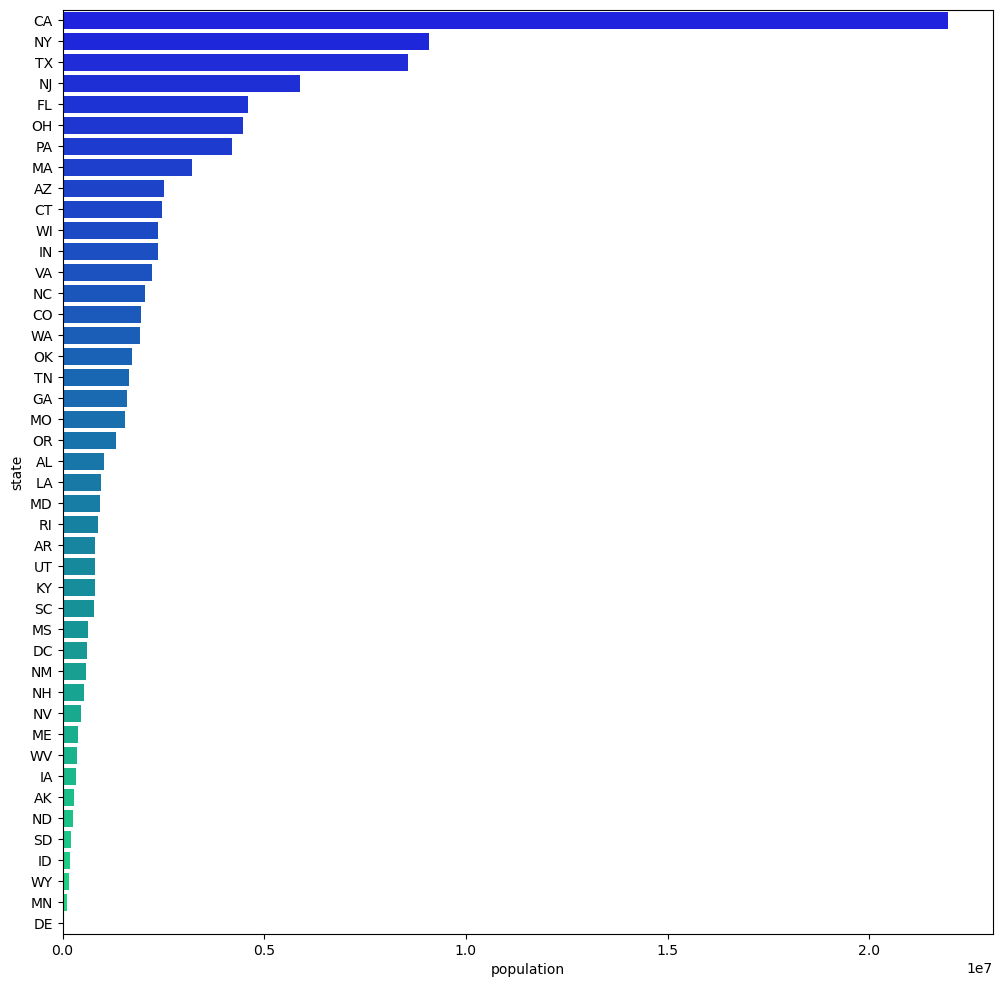

None


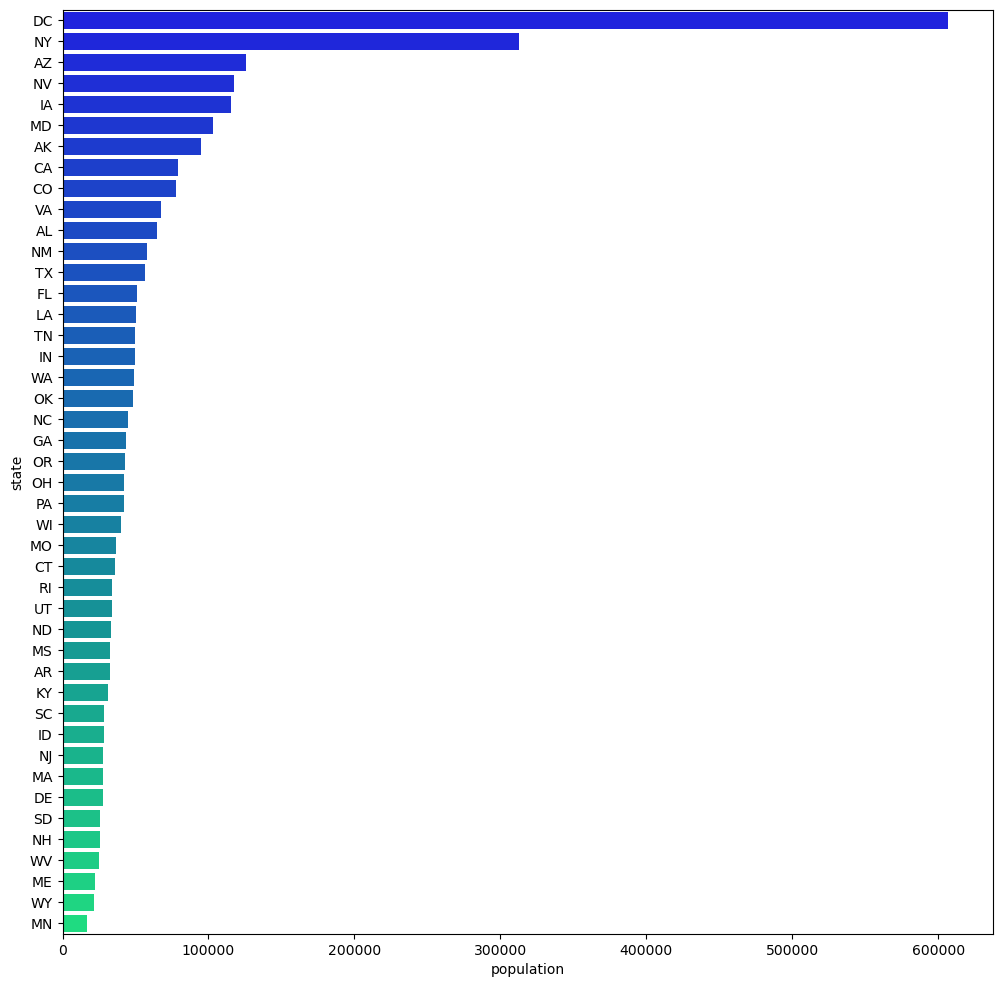

None


In [155]:
columns = df2.columns
def graph_by_state(col, estimator='mean'):
    if estimator == 'mean':
        state = df2.groupby('state')[col].mean().reset_index()
    elif estimator == 'median':
        state = df2.groupby('state')[col].median().reset_index()
    elif estimator == 'sum':
        state = df2.groupby('state')[col].sum().reset_index()
    else:
        print('estimator not recognized')
        
    state.sort_values(by=col, ascending=False, inplace=True)
    plt.figure(figsize=(12,12))
    sns.barplot(data=state, y='state', x=col, palette='winter')
    plt.show()
    
print(graph_by_state('population', estimator='sum'))
print(graph_by_state('population', estimator='mean'))

This plot shows the population in each state. California, New York, and Texas have the largest populations. Denver, Vermont, and Wyoming have the smallest populations.


To explore demographic factors, I created visualizations for median income, unemployment rates, poverty levels, and racial composition across states. 


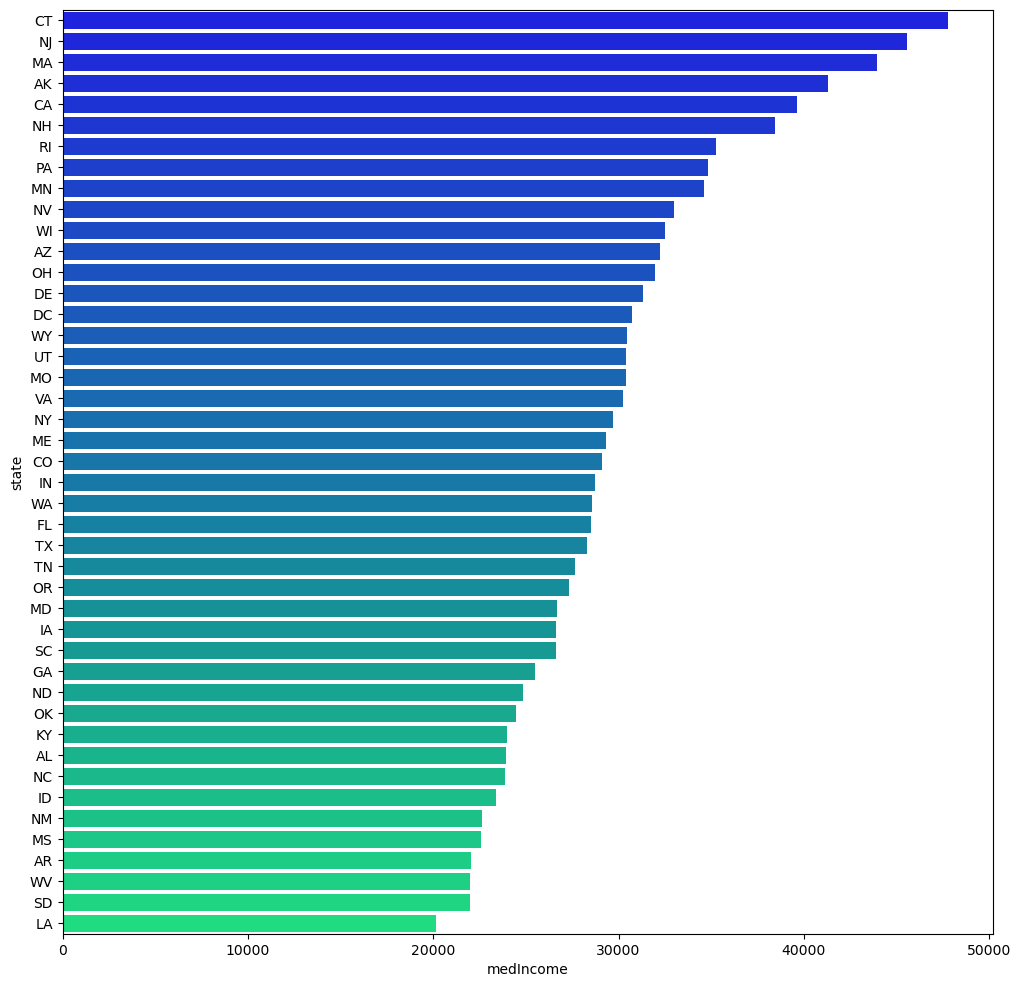

In [158]:
graph_by_state('medIncome')

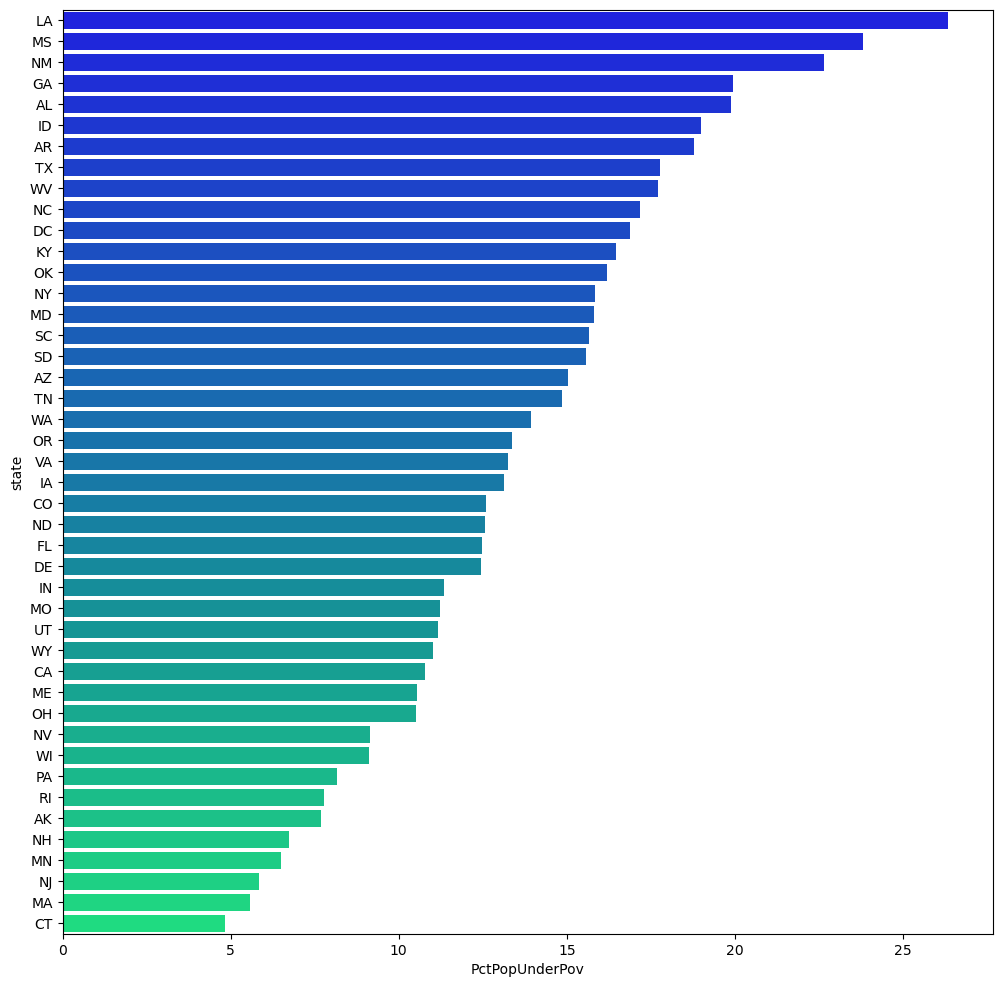

In [159]:
graph_by_state('PctPopUnderPov') # Percentage of population under poverty

The percentage of population under poverty is highly correlated with the median income. States with a higher percentage of the population under poverty tend to have lower median incomes, indicating a strong negative correlation.

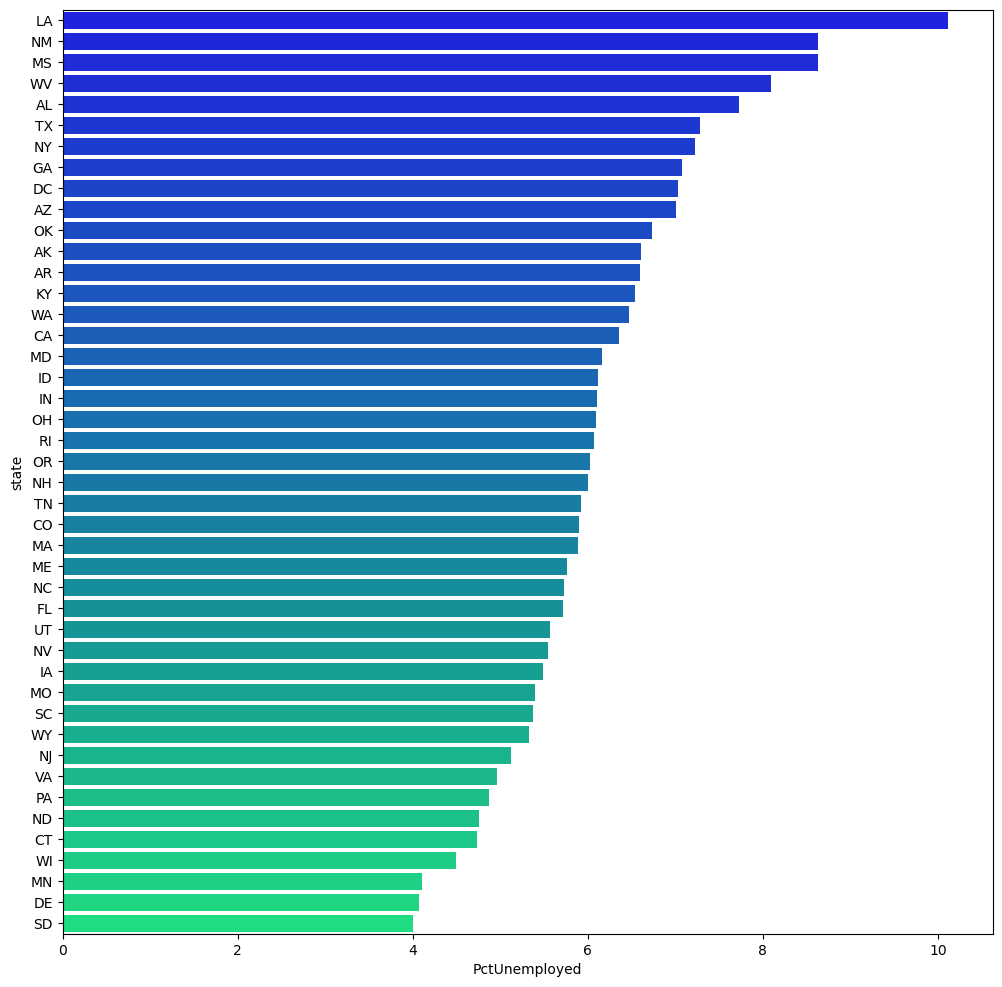

In [161]:
graph_by_state('PctUnemployed', estimator='mean') # Percent unemployed

#### Racial Composition

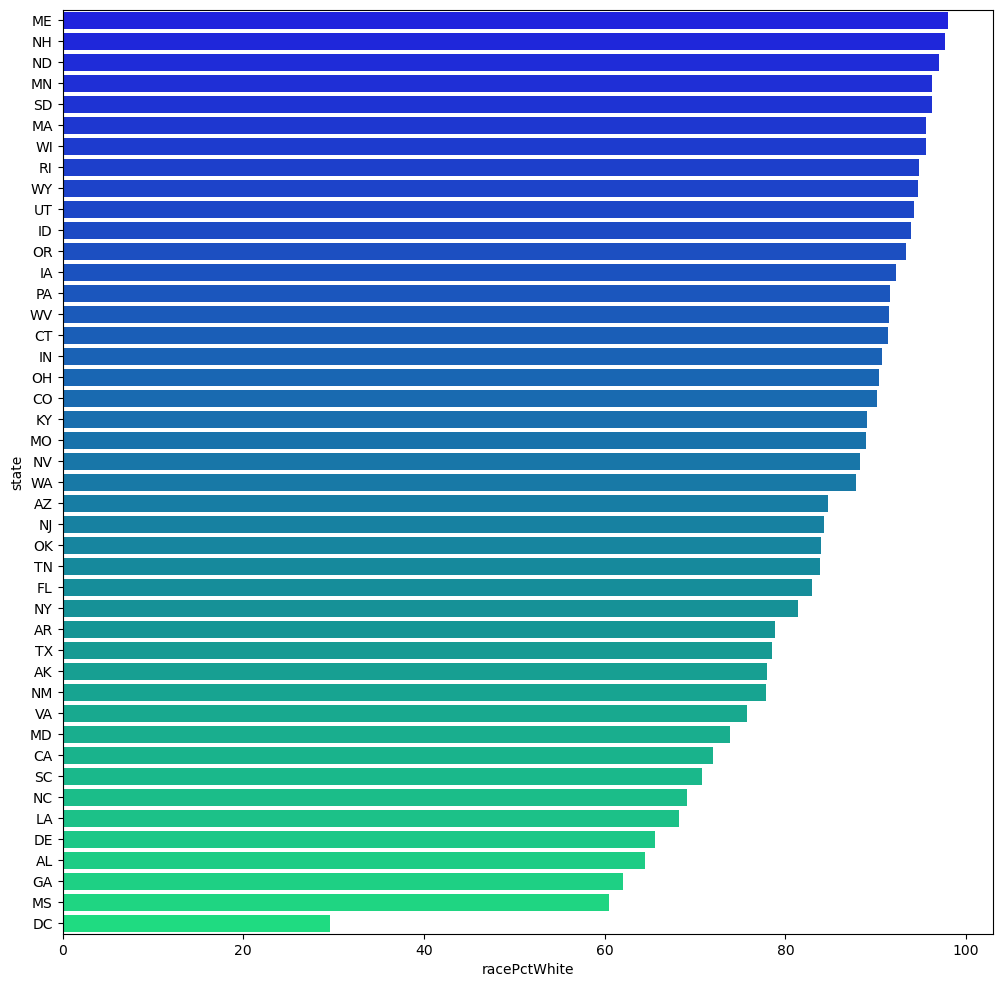

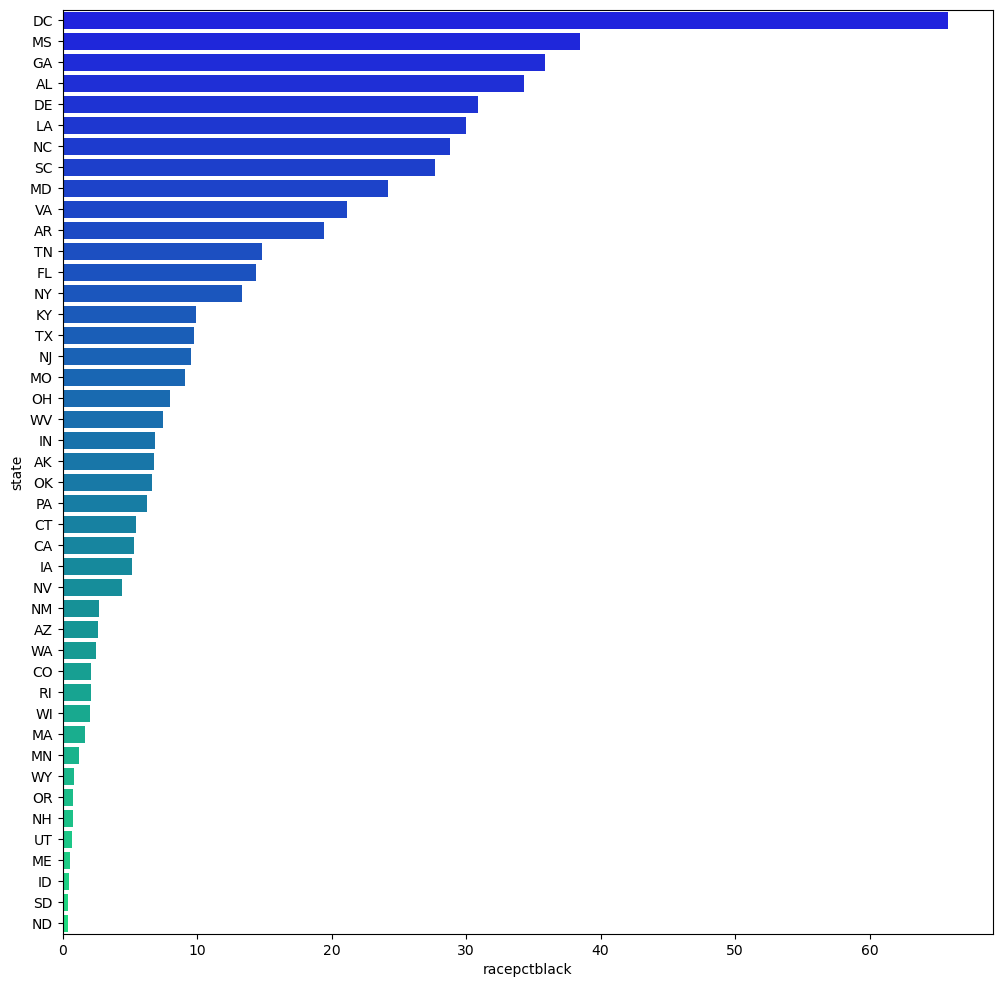

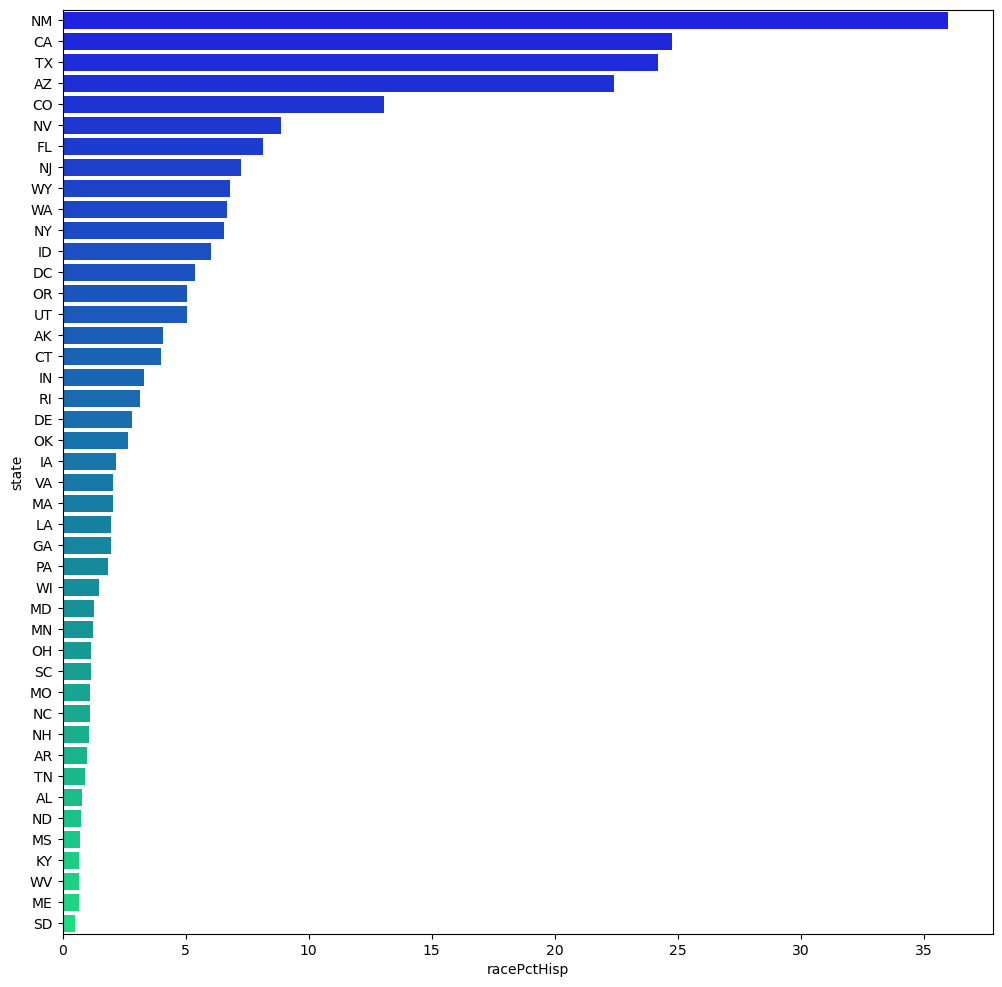

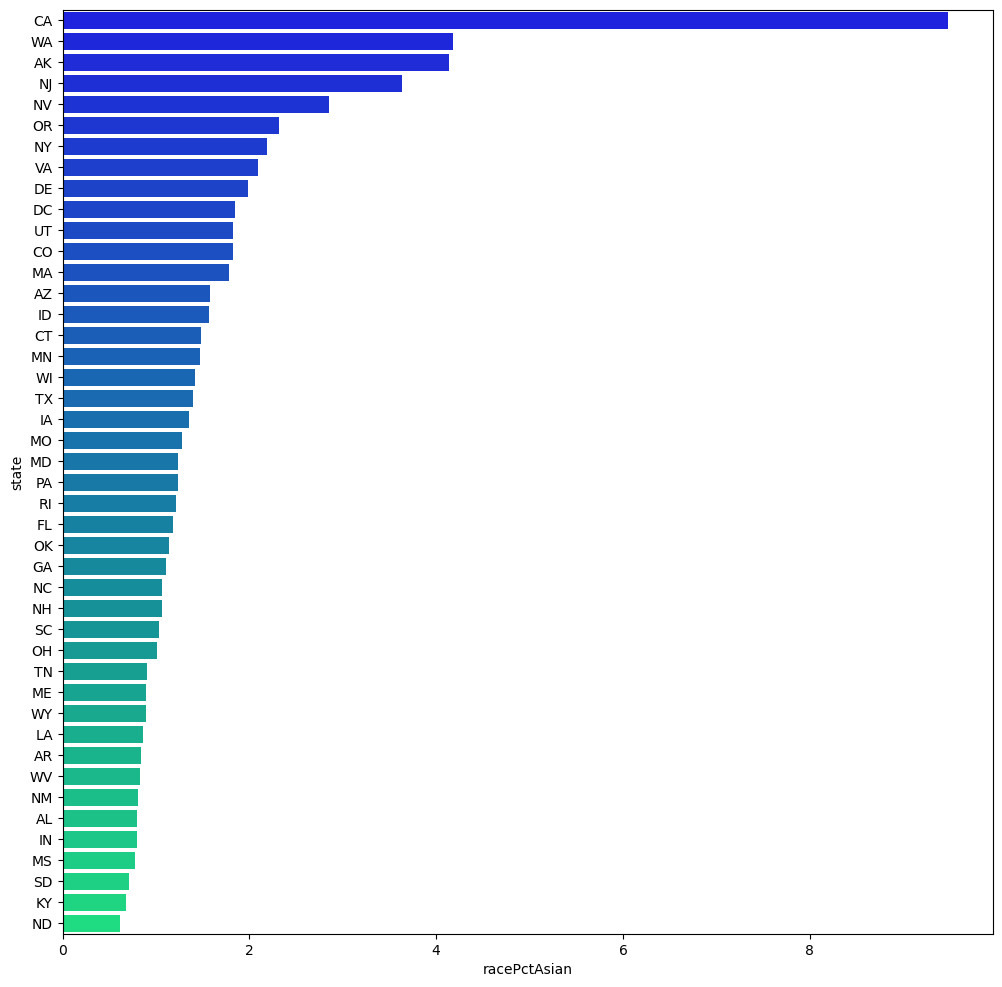

In [163]:
race_list = ['racePctWhite', 'racepctblack', 'racePctHisp', 'racePctAsian']

for race in race_list:
    graph_by_state(race, estimator = 'mean')

- White Americans: Represent the largest racial group in most states.
- African Americans: Have the largest populations in states like Mississippi, Georgia, Louisiana, and Washington D.C.
- Hispanic Americans: Have the largest populations in southwestern states, like New Mexico, Texas, Arizona, and California.
- Asian Americans: Are most prevalent in California and other Pacific states.

#### Foreign-Born Population

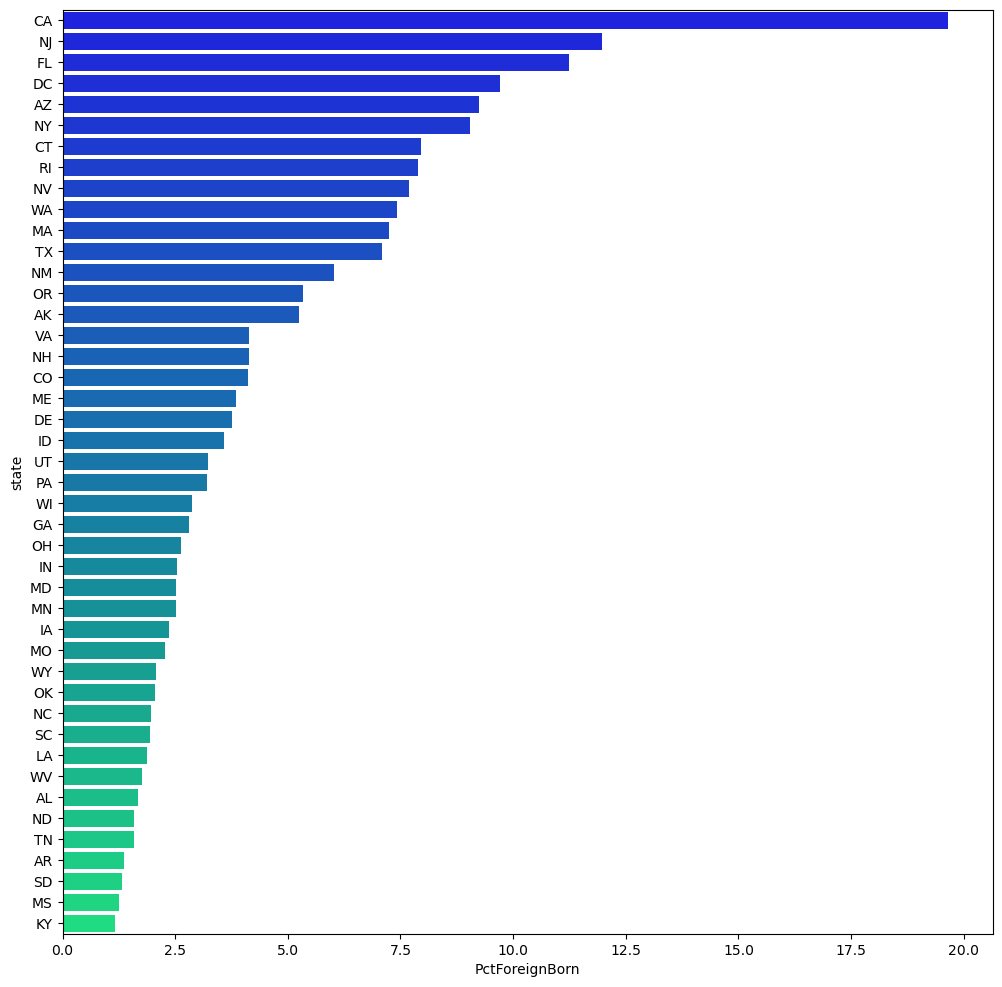

In [166]:
graph_by_state('PctForeignBorn', estimator='mean')

States with the highest foreign-born populations include California, New York, Florida, Washington DC, and New Jersey reflecting trends in immigration.


#### Crimes by State

To identify crime patterns, I analyzed the prevalence of different crimes across states.


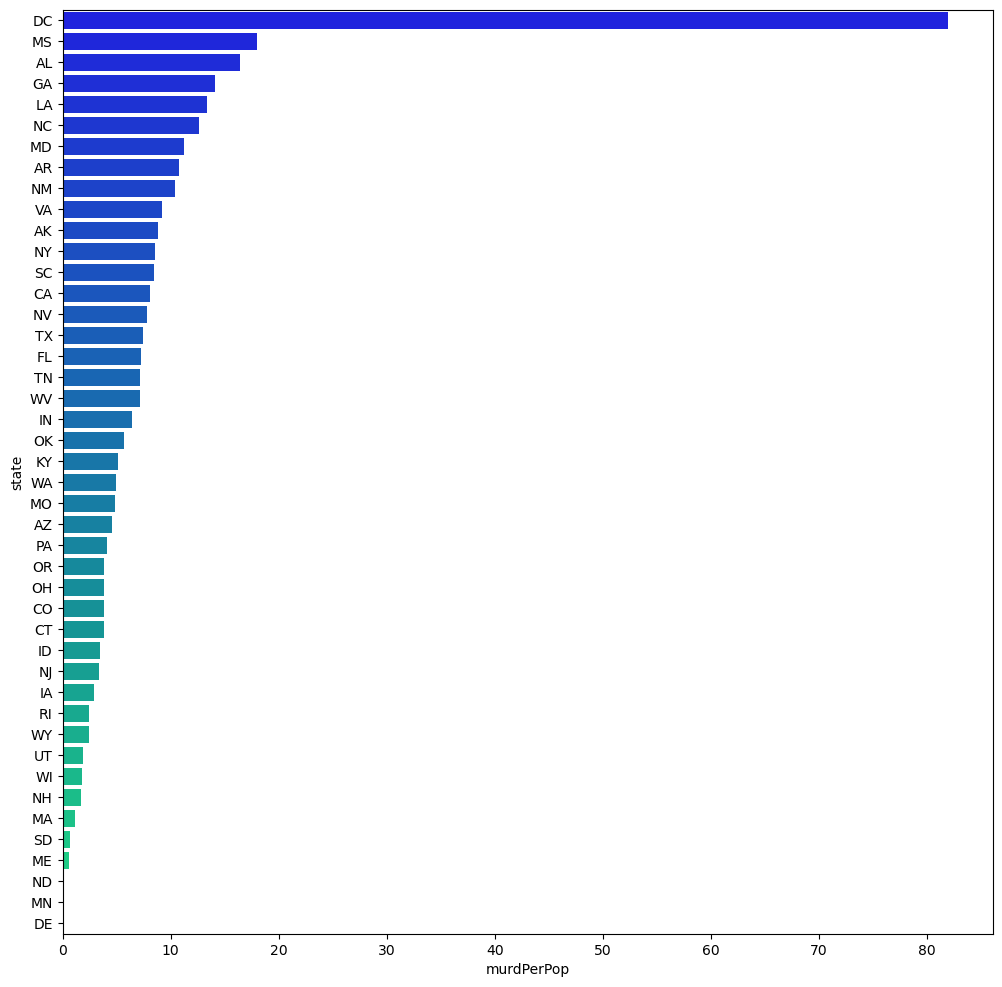

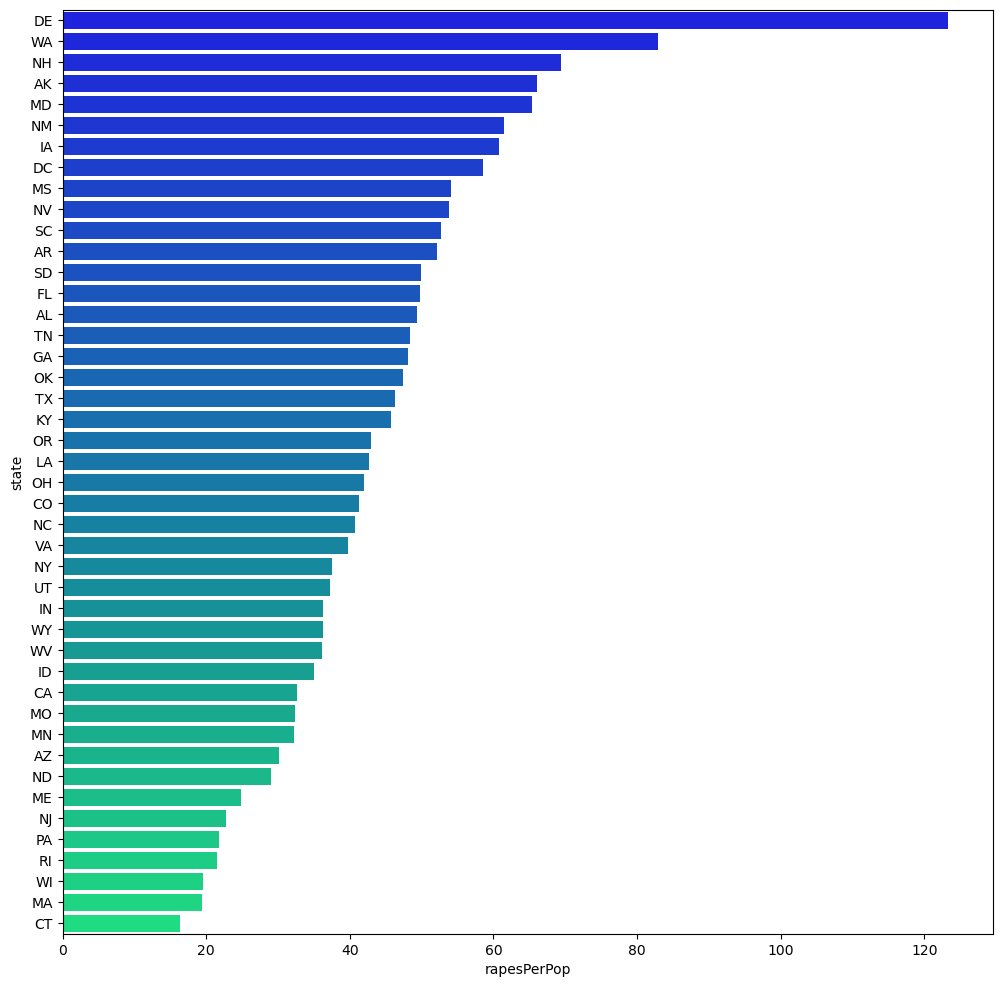

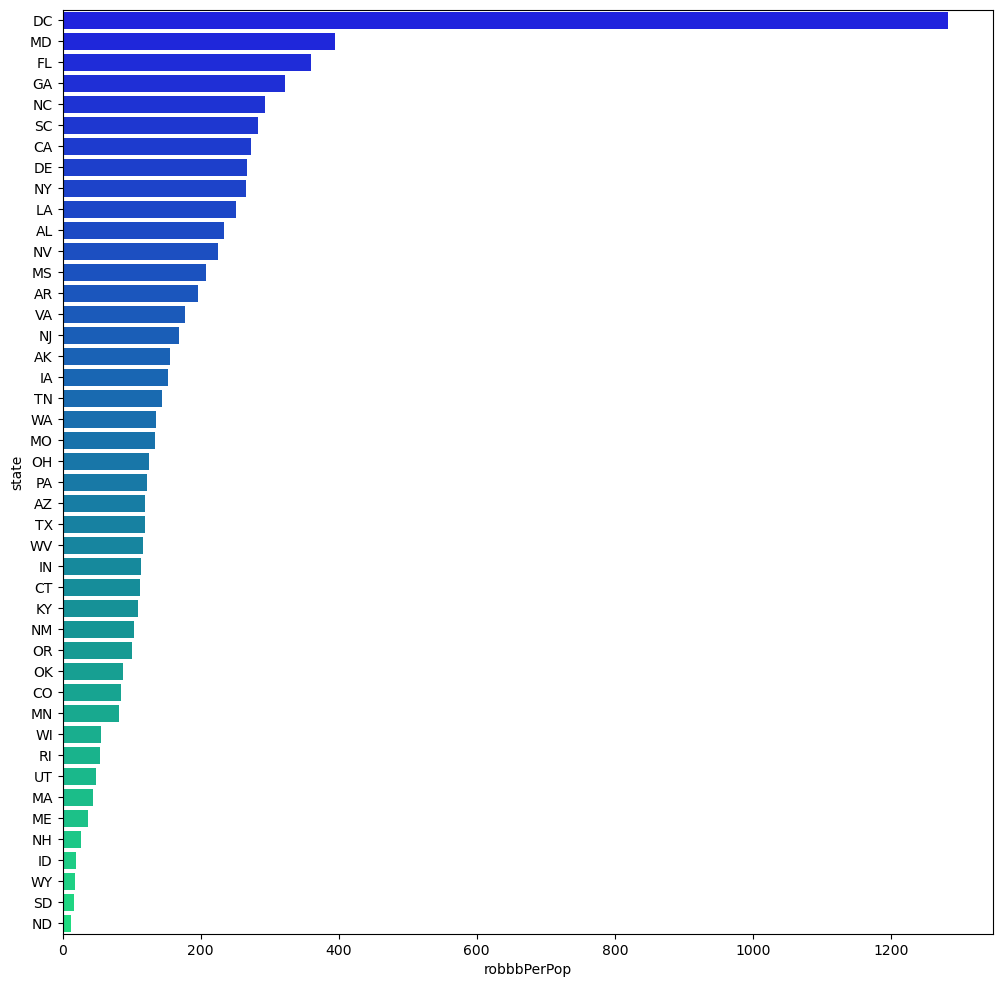

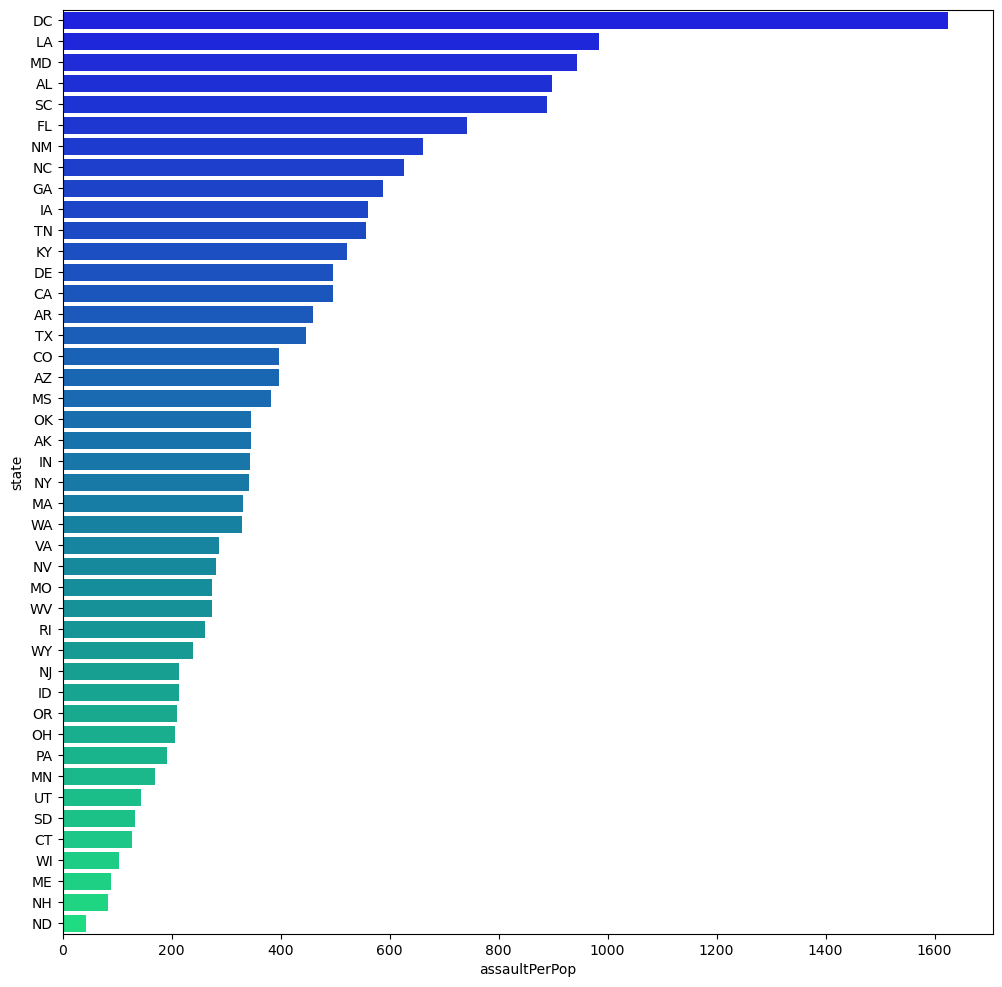

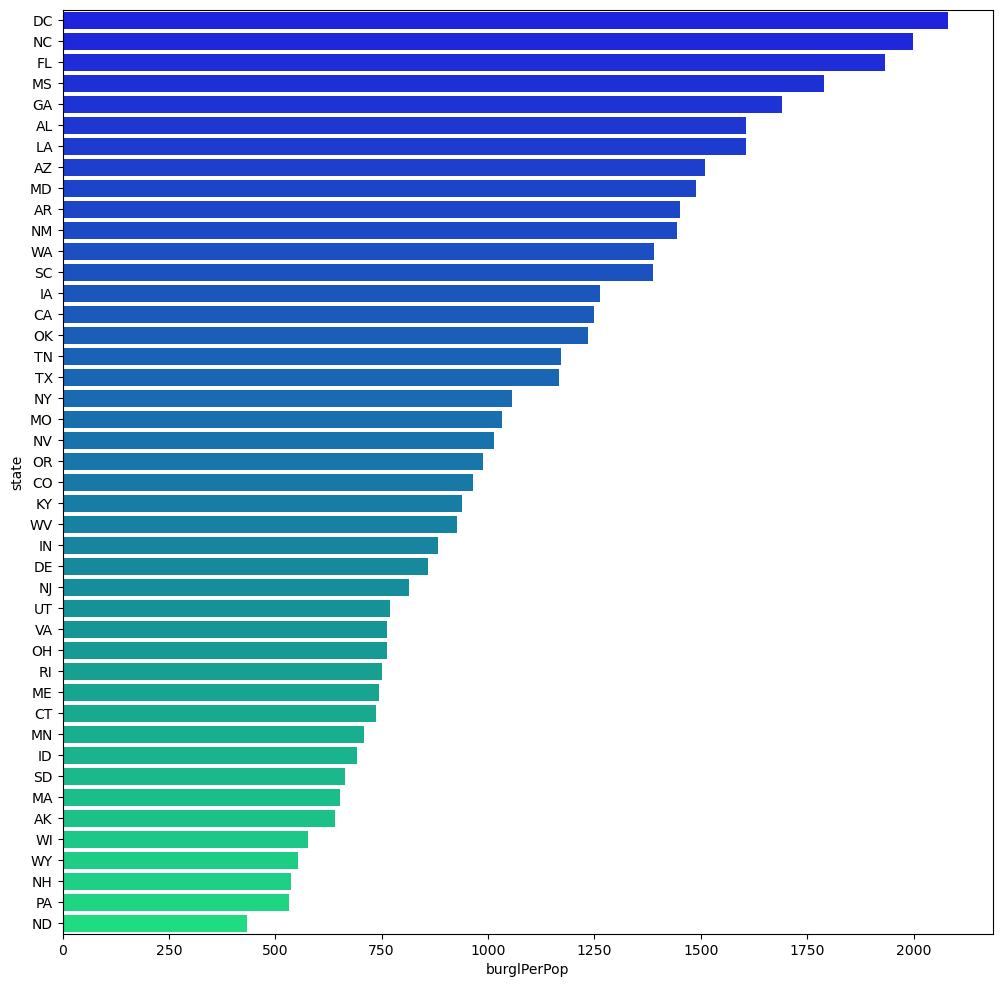

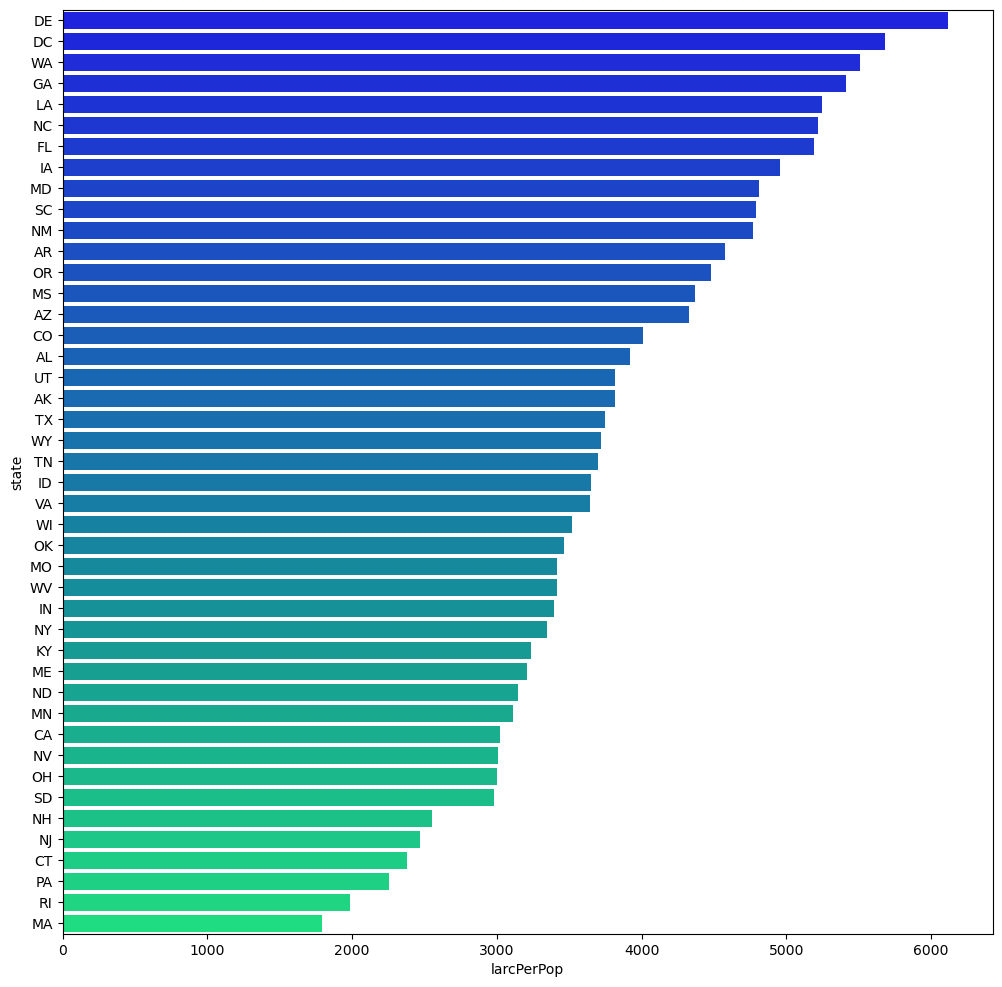

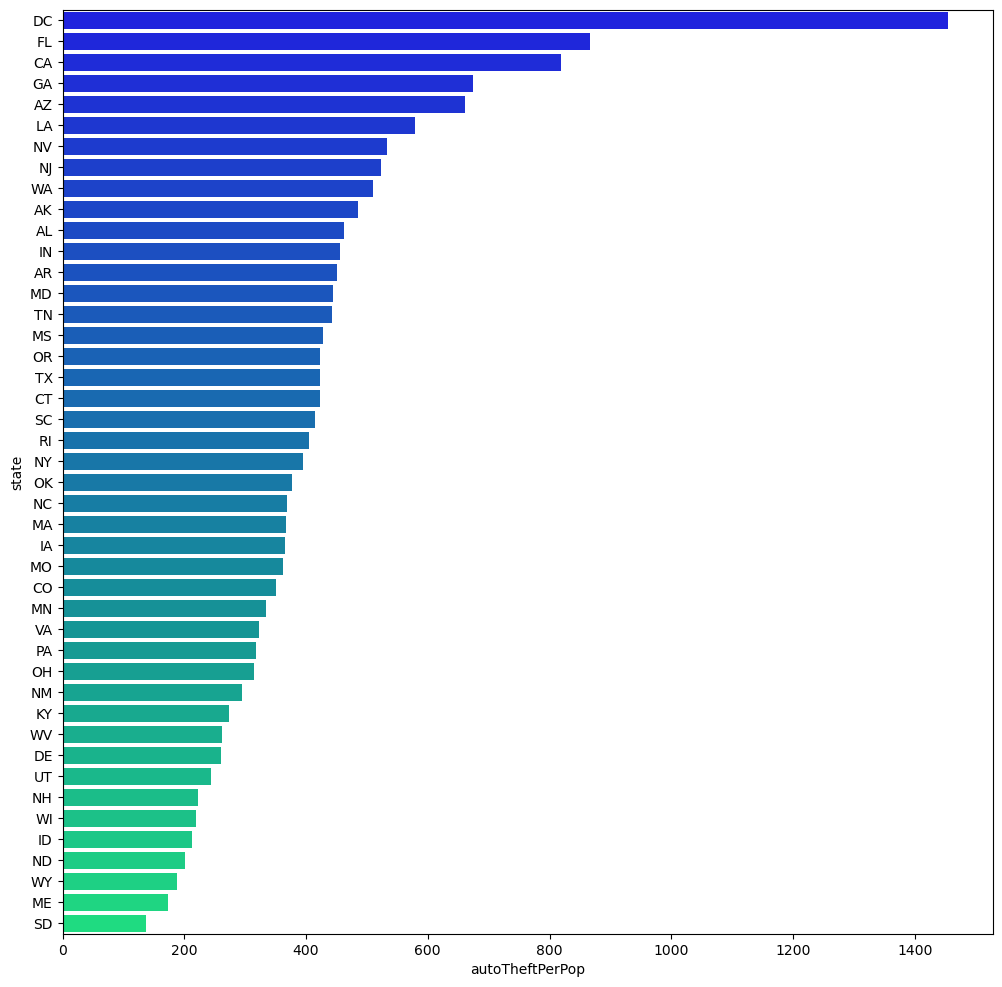

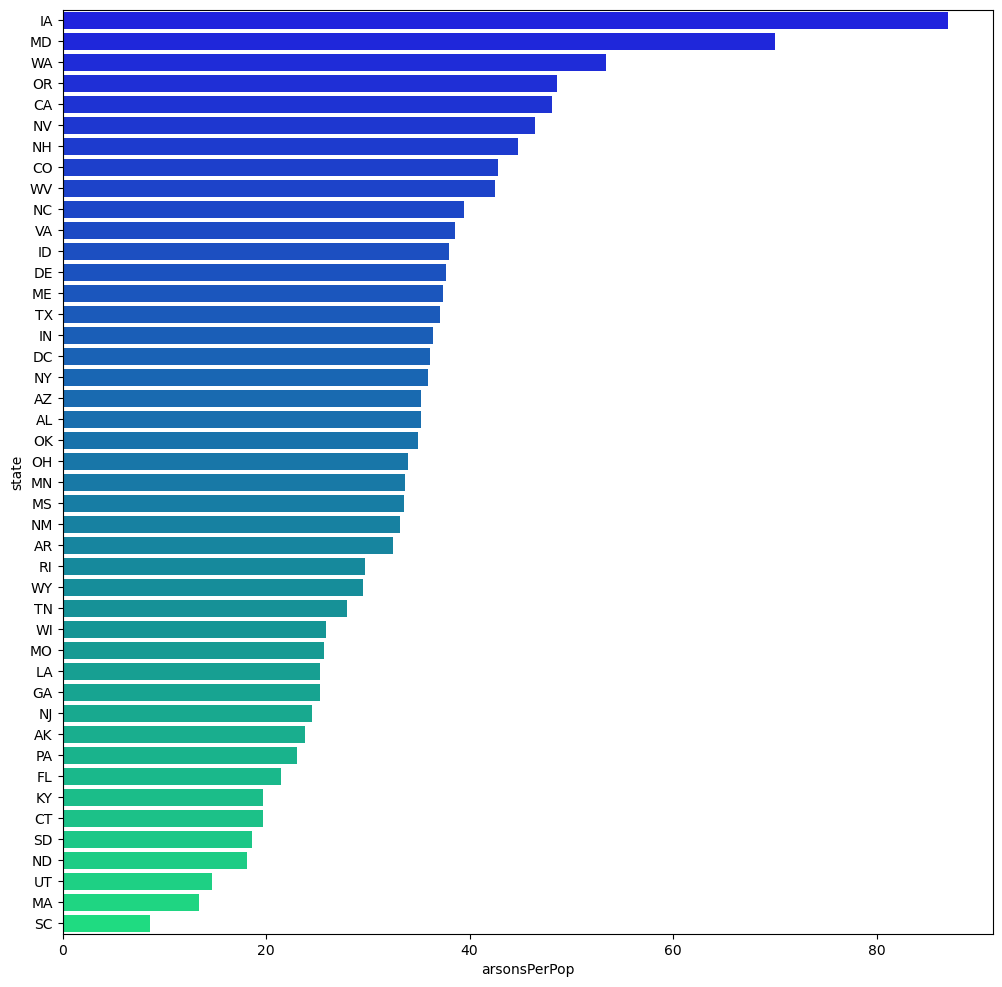

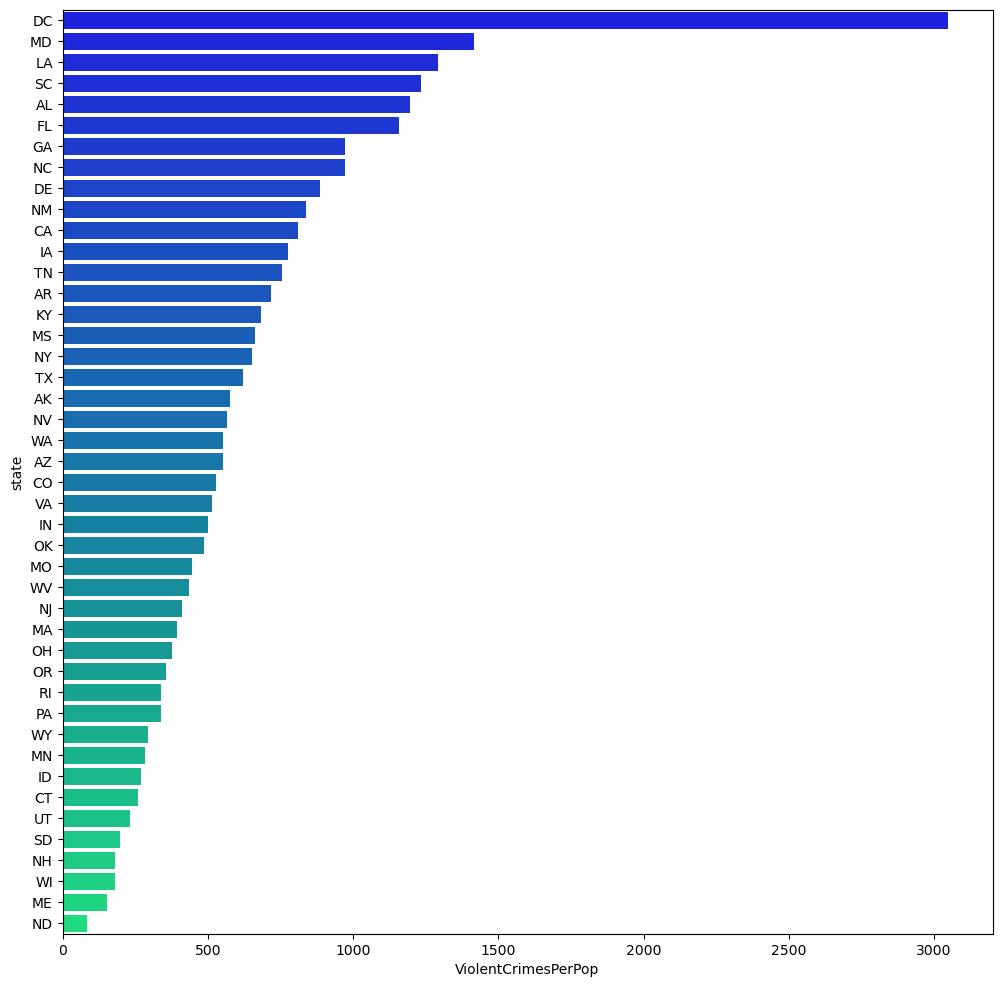

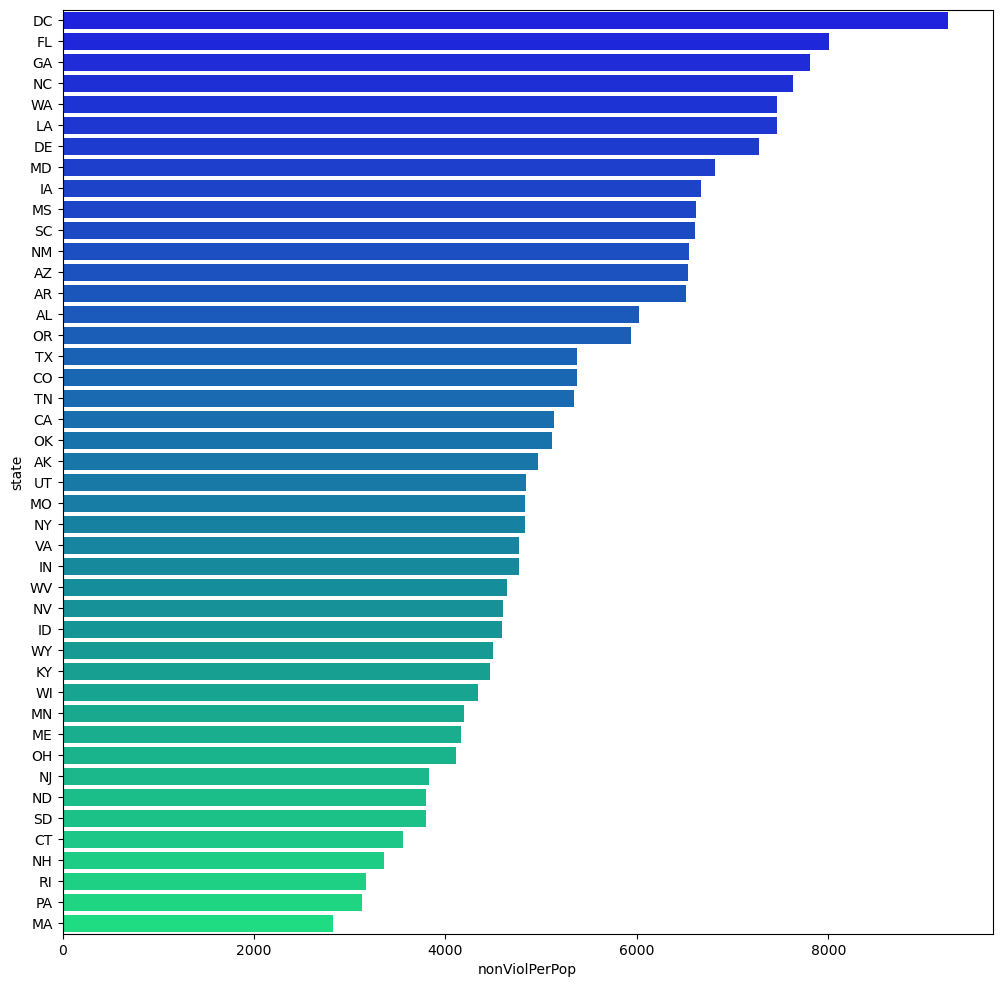

In [169]:
crime_list = ['murdPerPop', 'rapesPerPop', 'robbbPerPop', 'assaultPerPop', 
              'burglPerPop', 'larcPerPop', 'autoTheftPerPop', 'arsonsPerPop',
              'ViolentCrimesPerPop', 'nonViolPerPop']

for crime in crime_list:
    graph_by_state(crime)

Delaware ranks highest for larceny and rapes. DC has the highest rates for murder, robbery, assault, burglary, auto theft, and overall and nonviolent crimes. The results highlight DC as a crime hotspot.


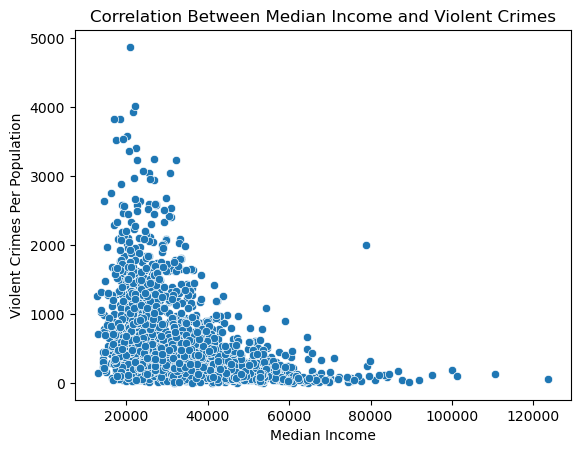

In [171]:
sns.scatterplot(data=df2, x='medIncome', y='ViolentCrimesPerPop')
plt.title("Correlation Between Median Income and Violent Crimes")
plt.xlabel("Median Income")
plt.ylabel("Violent Crimes Per Population")
plt.show()

The scatterplot shows how income relates to violent crime rates. Areas with lower median incomes tend to experience higher rates of violent crimes. On the other hand, communities where people make more money usually have fewer violent crimes.

This suggests that income levels may have a significant influence on how much crime happens in a community. Further analysis is needed to deepen understanding of these relationships.

#### Distribution of Target

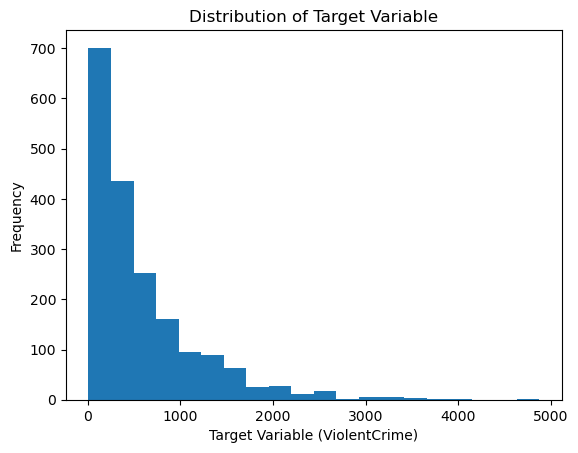

In [174]:
plt.hist(target, bins=20)
plt.xlabel('Target Variable (ViolentCrime)')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

The target variable distribution is skewed. This suggests that violent crime is not evenly distributed across all communities. I will use the function I created in earlier steps to transform the target variable to reduce the skewness, and after fitting the model I will compare it with other models. 

In [176]:
Y_transformed, numerical_v, categorical_v = seperate_cols(df2, target, log=True)

### Correlations

**Correlation Matrix**:
The heat map shows the correlations among various features. I will identify some of the variables that are highly correlated.

Correlation values range from -1 to 1 with the absolute value of 1 being the strongest correlation. 

    -  1: perfect positive correlation (red)
    -  0: no correlation (white)
    - -1: perfect negative correlation (blue)

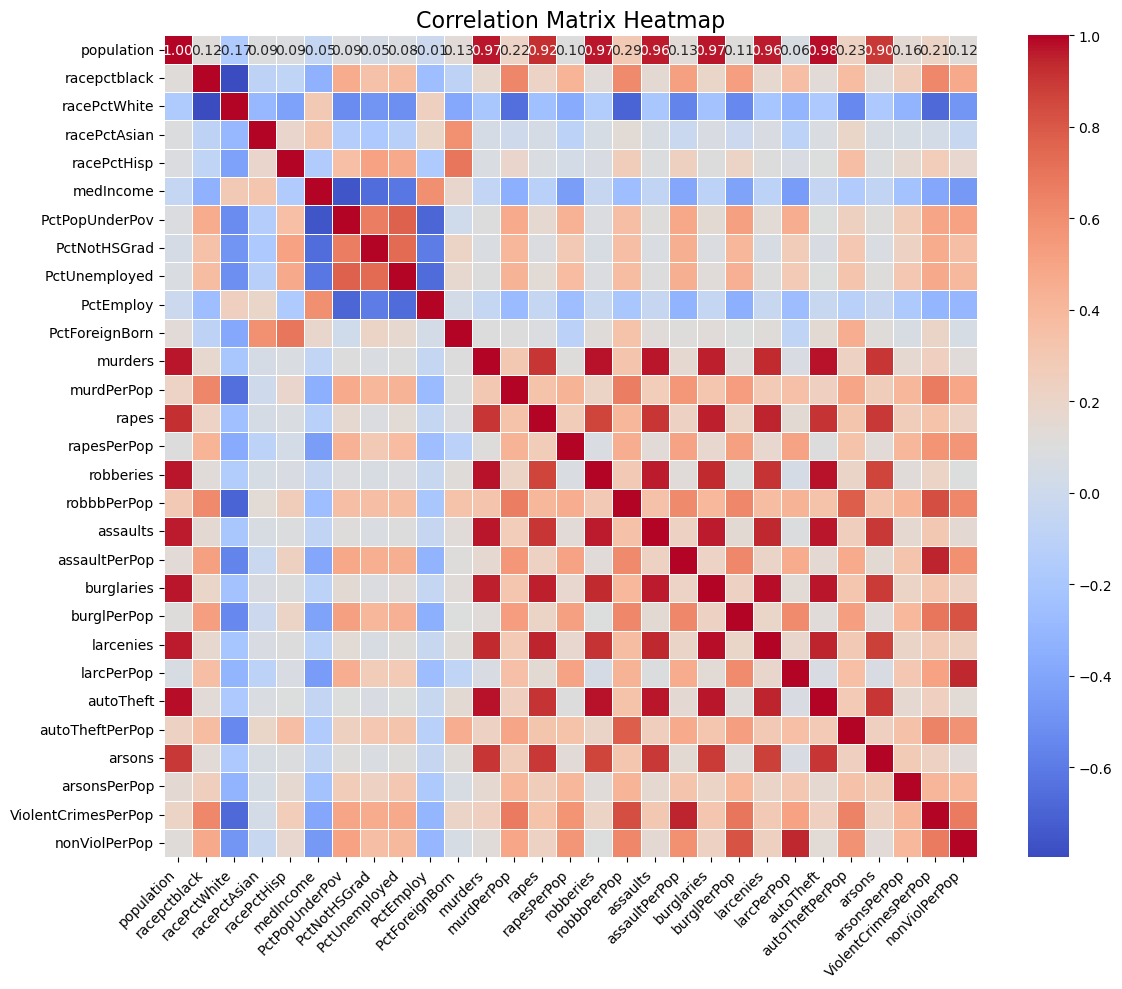

In [178]:
# Corr matrix
corr_matrix = numerical.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45, ha="right")  
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

**Obseravtions**:

There is a very strong positive correlation with violent crimes and murder, assault, rape, robbery, and burglaruy per population. This suggests locations with higher violent crime rates also tend to see higher rates in assualts, murders, and robberies, etc. There is also a very strong positive correlation with non-violent crimes and burglary, larceny, and autotheft per population. 

Population size has a very strong positive correlation with all crime (murders (0.966), robberies (0.967), burglaries (0.969), etc). As population size increase, crime also increases. Populatioaon size is a driver in crime rates. 

Population has a much lower correlation with "per pop" columns, such as murderPerPop (0.22) and assaultPerPop (0.13). This suggests crime rates per capita are less influenced by population size

African American population has a modertely postive correaltion with poverty, high school drop out, and crime metrics. These correlations suggest socioeconomic factors (poverty and education) may play a more significant role in crime than racial composition alone. White Americans shows inverse relationships.  

PctForeignBorn shows modest correlations with crime metrics. It positively correlates with racePctAsian and racePctHisp, highlighting demographic patterns rather than crime influences.

ViolentCrimesPerPop shows strong correlations with poverty (0.50) and lack of education (PctNotHSGrad: 0.46). This aligns with theories linking socioeconomic hardship to higher crime rates.

There is a very strong negative correlation between Income and poverty, employment, and education attained. Lower income correlates to higher poverty, higher high school dropout rates, and higher percentage of unemployment. This is expected and aligns with socioeconomic expecations.


In [180]:
# Closer look at correlation values
corr_matrix[corr_matrix != 1]

,population,racepctblack,racePctWhite,racePctAsian,racePctHisp,medIncome,PctPopUnderPov,PctNotHSGrad,PctUnemployed,PctEmploy,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
population,NaN,0.118945,-0.167715,0.088367,0.086588,-0.049082,0.085644,0.045869,0.079203,-0.014722,...,0.969380,0.108801,0.962781,0.063786,0.982953,0.229456,0.897983,0.156631,0.212076,0.119021
racepctblack,0.118945,NaN,-0.796628,-0.090804,-0.077529,-0.337881,0.462354,0.342260,0.373413,-0.257017,...,0.193418,0.526021,0.169212,0.365704,0.134061,0.370448,0.134578,0.253968,0.623833,0.474325
racePctWhite,-0.167715,-0.796628,NaN,-0.295994,-0.422373,0.292293,-0.525442,-0.485331,-0.513684,0.246790,...,-0.232038,-0.540261,-0.209481,-0.317527,-0.184370,-0.541996,-0.180619,-0.321659,-0.676357,-0.476579
racePctAsian,0.088367,-0.090804,-0.295994,NaN,0.190689,0.314184,-0.142832,-0.182047,-0.124247,0.195153,...,0.068633,-0.013579,0.070892,-0.096493,0.080434,0.198404,0.065584,0.054426,0.036044,-0.034742
racePctHisp,0.086588,-0.077529,-0.422373,0.190689,NaN,-0.158722,0.357248,0.511988,0.479525,-0.170603,...,0.102801,0.208989,0.102477,0.067724,0.099712,0.366490,0.093482,0.158330,0.264517,0.174622
medIncome,-0.049082,-0.337881,0.292293,0.314184,-0.158722,NaN,-0.759286,-0.663046,-0.620820,0.598038,...,-0.096797,-0.411557,-0.100995,-0.452629,-0.055839,-0.163522,-0.068915,-0.229557,-0.396187,-0.465541
PctPopUnderPov,0.085644,0.462354,-0.525442,-0.142832,0.357248,-0.759286,NaN,0.664791,0.771055,-0.689349,...,0.146067,0.519014,0.141969,0.454060,0.097897,0.236185,0.111843,0.273213,0.499213,0.510311
PctNotHSGrad,0.045869,0.342260,-0.485331,-0.182047,0.511988,-0.663046,0.664791,NaN,0.736842,-0.595242,...,0.085285,0.403587,0.064539,0.276848,0.073065,0.310563,0.075774,0.224200,0.466515,0.366500
PctUnemployed,0.079203,0.373413,-0.513684,-0.124247,0.479525,-0.620820,0.771055,0.736842,NaN,-0.664028,...,0.127570,0.444875,0.109132,0.290811,0.101494,0.327406,0.111835,0.309618,0.474968,0.392085
PctEmploy,-0.014722,-0.257017,0.246790,0.195153,-0.170603,0.598038,-0.689349,-0.595242,-0.664028,NaN,...,-0.048622,-0.342186,-0.033754,-0.264511,-0.034815,-0.116277,-0.039720,-0.173196,-0.312261,-0.304710


In [181]:
# Strong Correlations 
#remove .head() to view all strong corr > 0.6
round(corr_matrix[(corr_matrix >= abs(0.6)) & (corr_matrix != 1)], 2).head(1)

,population,racepctblack,racePctWhite,racePctAsian,racePctHisp,medIncome,PctPopUnderPov,PctNotHSGrad,PctUnemployed,PctEmploy,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
population,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.97,NaN,0.96,NaN,0.98,NaN,0.9,NaN,NaN,NaN


#### Splitting Data and Standardizing

The dataset is split into training and testing subsets. 70% of the data will be used to train the model and 30% of the data will be reserved for testing the model's performance on unseen data. After the split, standardization will be applied to the features.

**Standardization**: Many features such as population and income, vary drastically in scale. Standardizing helps make sure these differences don't dominate the model's results.

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split target and predictors
Y = result_df[['ViolentCrimesPerPop']]
X = result_df.drop(columns = target)

#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#Standardize data
scaler = StandardScaler()
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Training set shape: (1331, 32), Testing set shape: (571, 32)


## 3. Model Building

### Implementing Custom Linear Regression Algorithm
For this analysis, I will implement a Linear Regression Model from scratch using the **Normal Equation**. The Normal Equation provides an analytical way to find the coefficients of a linear regression model without relying on iterative optimization algorithms like Gradient Descent.

**The Normal Equation**

$$
  X^T X \theta^* = X^T y
$$

> X - feature matrix (with an intercept column added).
> 
> 𝑦 - target variable.
> 
> 𝜃 - vector of coefficients.

You can solve for theta by using `np.linalg.lstsq()` for the linear least squares solution. 


The training process will involve:
1. Adding an intercept column to the feature matrix.
2. Calculating the coefficients using the normal equation.
3. Validating the model using metrics like Mean Squared Error and R² Score to evaluate its performance.

In [187]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [188]:
y = Y.to_numpy()
x = X.to_numpy()

In [189]:
#Implement function to fit a model

def linreg_fit(x, y):
    """Computes regression coefficients using normal equation"""
    m = len(x)  
    assert len(y) == m
    u = np.ones(m) #intercept
    x =  np.c_[u, x]  #Adds a column

    theta = np.linalg.lstsq (x, y, rcond = None)[0]
    return theta
    
theta = linreg_fit(X_train, y_train)

## 4. Predictions and Validation

#### Predictions on Training and Test Data: 
After the coefficients 𝜃 are computed using the linear regression model, I will make predictions on both the training and test sets. These predictions will help evaluate how well the model fits the training data and generalizes to unseen data.

#### Model Validation: 
To assess the performance of the regression models, I will use:
- R² Score: Measures how well the model explains the variance in the dependent variable. Values close to 1 indicate better fit.
- Adj R²: Accounts for the number of predictors
- Mean Squared Error (MSE): Measures the average squared difference between the actual and predicted values. Lower values indicate better fit.
- Mean Absolute Error (MAE): Measures the average absolute error; measures prediction accuracy


In [191]:
def adjusted_r2(r2, n, p):
    """Calculates adjusted r2"""
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

In [192]:
#Prepartion for predictions
y = Y.to_numpy()
x = X.to_numpy()
X_train = np.c_[np.ones(X_train.shape[0]), X_train] #add intercept
X_test = np.c_[np.ones(X_test.shape[0]), X_test] #add intercept

# Predictions on train & test set
y_pred_train = X_train @ theta
y_pred_test = X_test @ theta

# Validation Metrics Train
# mse_train = mean_squared_error(y_train, y_pred_train)
# r2_train = r2_score(y_train, y_pred_train)
# print(f"Custom Model - Train MSE: {mse_train}, R^2: {r2_train}")

# Validation Metrics Test
r2_test = r2_score(y_test, y_pred_test)
adj_r2_test = adjusted_r2(r2_test, len(y_test), X_test.shape[1])
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Custom Model - \nR^2: {r2_test} \nAdj R^2: {adj_r2_test} \nMSE: {mse_test} \nRMSE: {rmse_test} \nMAE: {mae_test}")

Custom Model - 
R^2: 0.9999999998854344 
Adj R^2: 0.999999999878394 
MSE: 3.7468346400155814e-05 
RMSE: 0.00612113930573025 
MAE: 0.004033147950704311


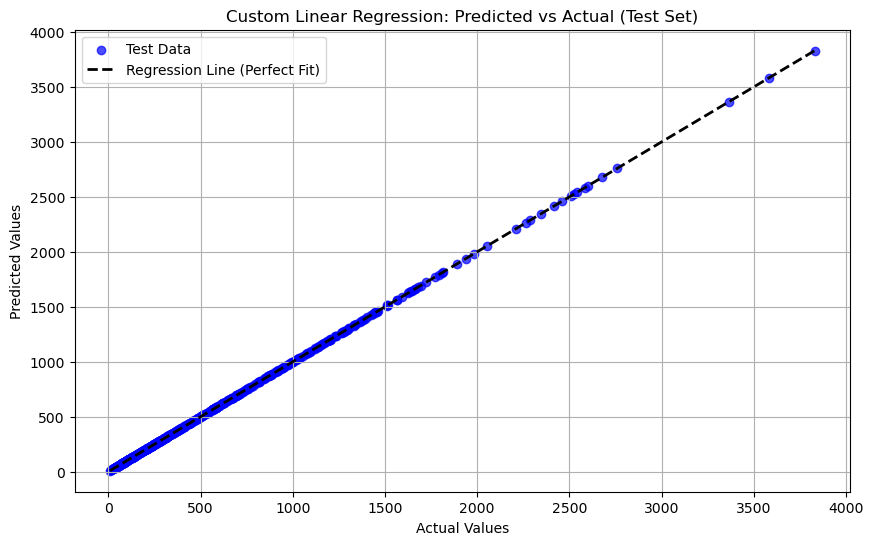

In [193]:
# Plot predicted vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, label="Test Data", color="blue")
x_line = np.linspace(y_test.min(), y_test.max(), 100)
y_line = x_line  # Perfect fit (y = x)
plt.plot(x_line, y_line, 'k--', lw=2, label="Regression Line (Perfect Fit)")

plt.title("Custom Linear Regression: Predicted vs Actual (Test Set)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

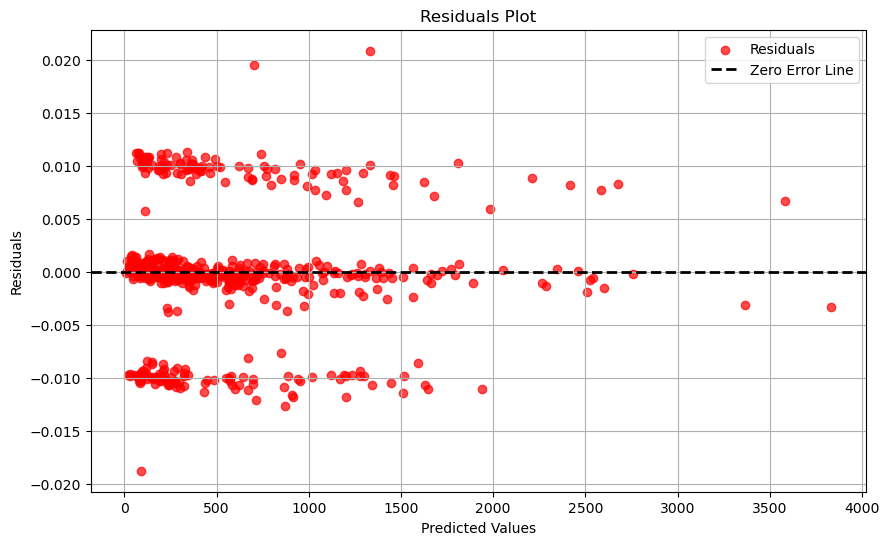

In [194]:
# Residuals Plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7, color="red", label="Residuals")
plt.axhline(y=0, color='k', linestyle='--', lw=2, label="Zero Error Line")
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()

The first plot shows how well the custom linear regression model predicts crime rates. The predicted values are closely aligned wih the regression line, with minimal deviation. This suggests the model is performing very well and the predictions are accuracte with very little error.

The residual plot shows the residuals appear to be randomly distributed across the zero line. There are some outliers. 

## Compare to Scikit-Learn

To validate the results from my custom linear regression models, I will compare it against a standard implementation of linear regression using Scikit-Learn. The Scikit-Learn model serves as a benchmark for evaluating the efficiency and correctness of the custom approach.


In [197]:
# Fit Scikit-Learn model
sklearn_model = LinearRegression(fit_intercept=True)
sklearn_model.fit(X_train, y_train)

# Make predictions
y_pred_sklearn_train = sklearn_model.predict(X_train)
y_pred_sklearn_test = sklearn_model.predict(X_test)

# Calculate Validation metrics
mse_sklearn_test = mean_squared_error(y_test, y_pred_sklearn_test)
rmse_sklearn = mean_squared_error(y_test, y_pred_sklearn_test, squared=False)
r2_sklearn = r2_score(y_test, y_pred_sklearn_test)
adj_r2_sklearn = adjusted_r2(r2_sklearn, len(y_test), X_test.shape[1])
mae_sklearn = mean_absolute_error(y_test, y_pred_sklearn_test)

#Scikit-Model Metrics:
print(f"Scikit-Model - \nR²:", r2_sklearn, "\nAdj R²:", adj_r2_sklearn, "\nMSE", mse_sklearn_test, "\nMAE:", mae_sklearn, "\nRMSE:", rmse_sklearn, "\n")

#Custom Model Metrics:
print(f"Custom Model - \nR²: {r2_test} \nAdj R²: {adj_r2_test} \nMSE: {mse_test} \nMAE: {mae_test} \nRMSE: {rmse_test}\n")

#Coefficients
print("Scikit-Learn Model Coefficients:\n", sklearn_model.intercept_, sklearn_model .coef_, '\n')
print("Custom Model Coefficients:\n", theta.T)

Scikit-Model - 
R²: 0.9999999998854344 
Adj R²: 0.999999999878394 
MSE 3.746834639986737e-05 
MAE: 0.004033147950524632 
RMSE: 0.006121139305706689 

Custom Model - 
R²: 0.9999999998854344 
Adj R²: 0.999999999878394 
MSE: 3.7468346400155814e-05 
MAE: 0.004033147950704311 
RMSE: 0.00612113930573025

Scikit-Learn Model Coefficients:
 [593.6864009] [[-4.55260279e-12 -6.78016867e-04  7.74994099e-04  1.32735146e-03
   6.37124781e-04  5.24354651e-04 -3.59099542e-05  1.65762383e-04
   1.61913381e-04  4.75416269e-05  7.84943050e-05  8.74521129e-07
   2.62954303e-03  9.44802041e+00  8.43778833e-05  3.58965802e+01
  -6.63088689e-04  2.38384607e+02 -5.97006680e-04  4.19103763e+02
  -3.26045345e-04  5.38572491e+00  1.26643425e-03  1.30605957e+01
  -1.59169873e-03  3.40241207e+00 -2.95159766e-04  2.60275950e-01
  -1.86088245e+01 -3.48208496e-03  1.06751327e-03  1.41311555e-03
   8.41811413e-04]] 

Custom Model Coefficients:
 [[ 5.93686401e+02 -6.78016867e-04  7.74994099e-04  1.32735146e-03
   6.371

The validation metrics are nearly identical when comparing the Custom Model to the Scikit-Learn Model. This validates that my custom model implementation captures the same relationships as Scikit-Learn. The coefficients for both models are very close, indicating the custom model is reliable. Any small differences are due to computational precision.

The R2 values are both very close to one, indicating the models explain most of the varaiability of the target variable. 

## Conclusion

In this analysis, I set out to understand the factors driving crime rates across U.S. cities, focusing on how population, socioeconomic, and demographic features influence crimes. Through data cleaning, EDA, and building a custom linear regression model, I uncovered some interesting insights into the relationships between these factors.

To address the questions I defined at the beginning of the study:

1. How do features like population, demographics, and socioeconomic factors influence crime rates in U.S. cities?
    - Areas with **higher populations** experience significantly higher rates of crime. Population size is strongly correlated with all crime types (violent and non-violent), emphasizing its importance as a driver of crime. This makes sense since more people generally means more opportunities for crime to occur. **Poverty levels** and **lack of education** are also strongly correlated with higher crime rates. These factors are critical contributors to crime rates. **Median income** is negatively correlated with crime, indicating that wealthier areas with higher median incomes tend to experience lower crime rates while areas with lower incomes experience more crime. This really highlights the role that economic stability plays in reducing crime and it aligns with sociological theories that **economic hardship**, **education**, and **population density** are key drivers of crime rates.


2. What features are most strongly correlated with crime rates?

   **Violent crimes** are most strongly correlated with population size (murder=0.96, rape=0.92, robbery=0.97, assault=0.96). It is also strongly correlated with poverty (r = 0.5), lack of education (r = 0.47), and unemployment (r=0.47). **Non-violent crimes** are strongly associated with population size (larceny=0.96, auto theft=0.98, etc). It is also highly correlated with poverty, unemployment, and lack of education. **Median income** has a strong negative correlation with crime. (r=-0.46 to -0.51)
  
4. Can a predictive model estimate crime rates based on these features?

   My custom linear regression model performed extremely well with a very high Adjusted R² and R² score (~0.9999). This shows that crime rates can be predicted with very little error using this model. However, very high R² values could suggest overfitting, likley due to *multicolinearity* among predictors. It might be worth trying techniques like Ridge or Lasso regression in the future to address this.

5. Are there distinguishable patterns across different crime categories (violent vs non-violent)?
    - Violent crimes are strongly linked to socioeconomic factors like poverty and lack of education.
    - Population size shows strong association with all crime categories. Crimes tend to occur more in densely populated areas
    - See EDA Section for more details and visuals on correlations
  
Policy efforts should focus on improving education and reducing poverty to address crime rates, especially in larger cities. This analysis gave me a much clearer picture of how different factors contribute to crime, but it also leaves room for future exploration. For example, it could be interesting to look at trends over time or consider how things like law enforcement policies and budgets play into the equation. 